
# Nowcasting ML — Lags de PIB & Sous-périodes (Pré-COVID / COVID / Reprise / Full)

Ce notebook complète le pipeline ML avec :  
- **Lags de la cible** \(y_{t-1}, y_{t-2}\) comme variables de type *bridge*,  
- **Évaluations par sous-périodes** : **Pré-COVID** (2013Q3–2019Q4), **COVID** (2020Q1–2020Q4), **Reprise** (2021Q1–2024Q4), **Full** (2013Q3–2024Q4),  
- Règle **Reprise** : l'apprentissage inclut la période **COVID** (pour refléter le ré-entraînement en contexte post-choc),  
- Choix des hyperparamètres par **TimeSeriesSplit** sur *train* uniquement, puis **OOS rolling** sur *test*,  
- Export des métriques par période et des prédictions.  


## 0) Imports & configuration

In [1]:

import warnings, os, json
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from typing import List, Dict, Optional
from dataclasses import dataclass

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,HistGradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))



## 1) Chemins de fichiers & paramètres globaux

- `csv_monthly` : indicateurs **mensuels stationnaires**  
- `csv_quarterly_target` : **PIB trimestriel YoY**  
- Colonnes : `date` (mensuel), `qper` (trimestriel), `y` (cible YoY)  


In [ ]:

# === A RENSEIGNER ===
csv_monthly = "Data/DataStationary.csv"            # ex: "data/monthly_features_stationary.csv"
csv_quarterly_target = "civgdp_growth.csv"

MONTHLY_DATE_COL = "date"
QUARTERLY_DATE_COL = "dates"
TARGET_COL = "GDP"

# Sous-périodes (bornes inclusives)
Q_PRE_START, Q_PRE_END   = "2013Q3", "2019Q4"
Q_COV_START, Q_COV_END   = "2020Q1", "2020Q4"
Q_REP_START, Q_REP_END   = "2021Q1", "2022Q4" 
Q_STAB_START, Q_STAB_END   = "2023Q1", "2024Q4"
Q_TEST_START, Q_TEST_END = Q_COV_START, Q_STAB_END   # COVID + Reprise

# TimeSeriesSplit / CV
N_SPLITS_TSCV = 5
MIN_TRAIN_OBS = 24
MIN_TRAIN_OBS_BASE = MIN_TRAIN_OBS  # ex. 24
MIN_TRAIN_OBS_COVID = 8             # minimum raisonnable pour lancer une régression simple


# Lags candidats à évaluer (ensembles de variables)
LAG_SETS = [(1,), (1,2),(1,4),(4,)]

# Modèles à tester
MODELS = ["ridge","lasso","elasticnet","svr_linear","svr_poly","svr_rbf","rf","etr"]


## 2) Utilitaires : dates & agrégation

In [3]:

def to_period_q(x):
    if isinstance(x, pd.Period):
        return x.asfreq('Q-DEC')
    try:
        s = str(x)
        if 'Q' in s:
            y, q = s.split('Q')
            return pd.Period(f"{y}Q{q}", freq='Q-DEC')
        dt = pd.to_datetime(x, errors='coerce')
        return dt.to_period('Q-DEC') if not pd.isna(dt) else pd.NaT
    except Exception:
        return pd.NaT

def to_period_m(x):
    if isinstance(x, pd.Period):
        return x.asfreq('M')
    try:
        dt = pd.to_datetime(x, errors='coerce')
        return dt.to_period('M') if not pd.isna(dt) else pd.NaT
    except Exception:
        return pd.NaT

def aggregate_monthly_to_quarterly(df_m, method='mean'):
    grp = df_m.groupby(df_m.index.asfreq('Q-DEC'))
    return grp.mean() if method=='mean' else grp.sum()

# ---------- LOG HYPERPARAMS : utils ----------
import os, json, datetime
from pathlib import Path

HP_EVENTS = []  # journal en mémoire (on dump à la fin)
HP_DIR = Path("exports_ml_subperiods")
HP_DIR.mkdir(parents=True, exist_ok=True)

def _extract_lagset_from_columns(cols):
    """Retourne la liste triée des lags présents dans la liste de colonnes."""
    lags = []
    for c in cols:
        if isinstance(c, str) and c.startswith("y_lag"):
            try:
                lags.append(int(c.replace("y_lag","")))
            except:
                pass
    return sorted(set(lags))

def _save_cv_results(gcv, regime_label, model_name):
    import pandas as pd
    df = pd.DataFrame(gcv.cv_results_)
    df.to_csv(HP_DIR / f"cvgrid_{regime_label}_{model_name}.csv", index=False)

def _save_best_params(best_params, regime_label, model_name):
    with open(HP_DIR / f"besthp_{regime_label}_{model_name}.json", "w", encoding="utf-8") as f:
        json.dump(best_params, f, indent=2, ensure_ascii=False)

def _append_hp_event(event: dict):
    """Ajoute un enregistrement au journal en mémoire + append JSONL sur disque (sécurité)."""
    HP_EVENTS.append(event)
    with open(HP_DIR / "hp_tuning_log.jsonl", "a", encoding="utf-8") as f:
        f.write(json.dumps(event, ensure_ascii=False) + "\n")



## 3) Chargement des données & fusion M→Q

In [ ]:

m = pd.read_csv(csv_monthly)
q = pd.read_csv(csv_quarterly_target)

assert MONTHLY_DATE_COL in m.columns
assert QUARTERLY_DATE_COL in q.columns and TARGET_COL in q.columns

m['__mper'] = m[MONTHLY_DATE_COL].apply(to_period_m)
q['__qper'] = q[QUARTERLY_DATE_COL].apply(to_period_q)

m = m.dropna(subset=['__mper']).set_index('__mper').sort_index()
q = q.dropna(subset=['__qper']).set_index('__qper').sort_index()

# Colonnes numériques des mensuels
num_cols_m = m.select_dtypes(include=[np.number]).columns.tolist()
Xm = m[num_cols_m].copy()

# Agrégation M -> Q (moyenne trimestrielle)
Xq = aggregate_monthly_to_quarterly(Xm, method='mean')

# Fusion (index trimestriel)
D = q[[TARGET_COL]].join(Xq, how='left')
D.index.name = 'qper'
D = D.sort_index()

print("Taille D:", D.shape)
display(D.head())


Taille D: (46, 56)


,GDP,cacao,imp,CPI,inflation,ipc_alim,ipc_habill,ipc_ameub,ipc_loge,ipc_sante,ipc_transport,ipc_com,ipc_hotel,tib_credit_total,tib_credit_admin_centrale,tib_credit_particuliers,tib_credit_snf_pub,tib_credit_assurance_fonds,tib_credit_snf_priv,tib_credit_autres_inst_depots,tib_credit_personnel_banque,tib_credit_immo,tib_credit_export,tib_credit_tresorerie,tib_credit_duree_1_3m,tib_credit_duree_6m_1a,tib_credit_duree_1_2a,tib_credit_duree_5_10a,tib_credit_duree_gt10a,tib_depot_total,tib_depot_admin_centrale,tib_depot_particuliers,tib_depot_imf,tib_depot_assurance_fonds,tib_depot_snf_priv,tib_depot_entreprise_indiv,tib_depot_autres_inst_depots,tib_depot_personnel_banque,tib_depot_terme,tib_depot_epargne_special,tib_depot_bons_caisse,tib_depot_duree_lt1m,tib_depot_duree_1_3m,tib_depot_duree_3_6m,tib_depot_duree_6m_1a,tib_depot_duree_1_2a,monnaie_circ_encaisses_banques,Travail,Stage,argent,mean_ntl_dnb,mean_evi,mean_vhi,mean_ndvi,mean_no2,mean_pcp
qper,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013Q3,7.4,-1.019788,-20.040140,1.286212,2.288736,1.286486,7.402553,3.102263,1.741759,-2.121338,-0.627747,-0.060369,0.595000,-7.287880,6.013049,-13.132316,-1.232309,-38.914856,-9.064479,27.438067,48.768863,-22.381145,-28.566932,-6.663593,-9.077867,-2.840715,-32.338214,-40.545350,-4.452871,-0.716841,11.358508,-1.063752,-15.404302,-8.503278,-0.319719,-8.742480,-7.984512,21.089024,-0.523899,0.000000,-0.380702,-0.204977,-2.013836,5.828023,17.006344,-3.785435,2.894004,-11.271445,-2.850877,1.414141,-3.620995,-0.490436,-2.533467,1.451988,-7.773071,-14.473140
2013Q4,10.0,12.723919,35.203681,-0.985431,1.077008,-0.988144,5.861511,3.240476,0.756577,-1.416807,-0.062562,-0.251876,0.271519,-15.851663,2.584815,-70.675293,3.972994,-36.060482,-16.056631,-47.530720,46.044828,-17.621628,4.234883,-20.160623,-17.581774,-13.842286,-54.584300,3.192426,13.724243,0.974656,10.499952,-4.335893,-8.447535,-4.836884,4.087100,-10.087025,-6.524058,12.834232,3.236461,4.091168,-14.688962,0.772783,-2.059212,-28.082903,-4.930774,4.634178,9.845944,-12.567204,-8.966589,40.833333,-413.904271,-2.074880,-6.585919,-2.833382,-8.220190,-5.232743
2014Q1,7.8,33.778847,21.806910,-3.746303,-0.022002,-3.718243,5.070606,3.064434,0.688912,-0.149981,-0.138795,0.719329,0.980314,-25.739789,-7.452998,-32.409811,-2.395197,4.138802,-28.913212,-13.494293,-11.648239,-21.676132,-65.807244,-30.298365,-37.730754,-20.464092,-1.591170,-13.591011,1.448221,-0.992500,-6.437118,-2.892726,-5.161534,-1.481871,-1.293558,5.338040,-13.564914,17.338269,-1.297319,14.439228,29.802298,-0.710405,-0.553268,10.168229,-4.742522,-2.485311,1.104990,-19.179894,-1.046734,51.839827,-5.725721,0.665382,1.880141,1.116434,-15.949693,32.101394
2014Q2,8.8,33.705562,35.167199,-1.899367,0.427392,-1.898428,3.557529,3.033932,0.637608,0.363896,0.261094,0.006803,1.363605,-4.871601,-46.541087,15.561261,18.737437,-8.532242,0.815413,-53.276280,46.682586,-8.026266,-15.924025,-1.649456,-7.232889,-2.962176,-17.083750,-8.289241,2.261059,-2.389059,-20.808961,-0.089395,18.951616,-13.678675,-6.243470,-6.167595,26.225978,-14.680837,-1.883028,18.078549,1.481230,4.790106,-0.898186,-8.103726,1.644991,-5.610793,5.206943,-15.853322,-15.931373,11.851852,-17.371097,-2.674965,6.146539,-2.149278,1.625300,25.880711
2014Q3,8.5,31.084641,21.052587,-1.087828,0.615679,-1.085188,2.552421,1.797318,1.058315,1.876422,-0.123038,0.060922,1.447365,-3.878824,222.112783,1.260559,26.123651,14.770802,4.457602,-14.197591,37.143450,-7.845830,163.796858,-4.464337,-7.102984,-7.773452,174.397131,139.148445,21.427786,-1.201740,12.419648,-9.522941,25.330087,-1.675965,-2.596185,12.446595,22.137603,5.882767,-1.059073,0.000270,-17.280091,-0.792133,-1.704386,-9.890802,-0.405339,-1.387693,-7.041587,-16.268199,-11.575890,18.055556,20.734990,3.772800,0.437050,0.845349,-4.238866,34.077810



## 4) Lags du PIB (bridge features)
On ajoute \(y_{t-1}\) et \(y_{t-2}\) en colonnes (sans fuite d'information).  
Le pipeline choisira ensuite la variante `(1,)` ou `(1,2)` via la grille.


In [5]:

# Liste des features initiales (hors cible)
base_feats = [c for c in D.columns if c != TARGET_COL]

# Ajouter lags globalement (pas de fuite : pour t, on utilise t-1, t-2)
D['y_lag1'] = D[TARGET_COL].shift(1)
D['y_lag2'] = D[TARGET_COL].shift(2)
D['y_lag4'] = D[TARGET_COL].shift(4)

# Catalogues de features par option de lags
FEATS_BY_LAGSET = {
    (1,):   base_feats + ['y_lag1'],
    (1,2):  base_feats + ['y_lag1','y_lag2'],
    (1,4) : base_feats + ['y_lag1','y_lag4'],
    (4,): base_feats + ['y_lag4'],
}

# série cible & index
y_full = D[TARGET_COL].copy()
qper   = D.index.copy()


## 5) Préprocesseur & grilles d'hyperparamètres

In [ ]:

from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSubsetter(BaseEstimator, TransformerMixin):
    """
    Sélectionne un sous-ensemble de colonnes par nom (compatible GridSearchCV).
    IMPORTANT: ne pas modifier 'columns' dans __init__ pour rester clonable.
    """
    def __init__(self, columns=()):
        self.columns = columns

    def fit(self, X, y=None):
        # Juste mémoriser les colonnes réellement disponibles
        self._available_cols_ = list(X.columns)
        return self

    def transform(self, X):
        # Intersecter pour éviter KeyError si une colonne manque
        keep = [c for c in self.columns if c in X.columns]
        return X.loc[:, keep]

    def get_feature_names_out(self):
        return np.array(list(self.columns))


def make_base_pipeline(model):
    return Pipeline(steps=[
        ("subset", FeatureSubsetter(columns=())),    
        ("imp",    SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("vt",     VarianceThreshold(0.0)),
        ("model",  model),
    ])


def epsilon_grid(y):
    iqr = (y.quantile(0.75) - y.quantile(0.25))
    eps0 = float(iqr/13.49) if (iqr is not None and iqr>0) else 0.1
    return [max(eps0*0.8,1e-4), eps0, eps0*1.2]

EPS_GRID = epsilon_grid(y_full)

def get_model_and_grid(name: str):
    if name == "ridge":
        model = Ridge(max_iter=20000, random_state=42)
        grid  = {"model__alpha":[1e-3,1e-2,1e-1,1,10,100]}
    elif name == "lasso":
        model = Lasso(max_iter=20000, random_state=42)
        grid  = {"model__alpha":[1e-3,1e-2,1e-1,1,10,100]}
    elif name == "elasticnet":
        model = ElasticNet(max_iter=20000, random_state=42)
        grid  = {"model__alpha":[1e-3,1e-2,1e-1,1,10,100], "model__l1_ratio":[0.1,0.2,0.3,0.5, 0.9]}
    elif name == "svr_linear":
        model = SVR(kernel="linear")
        grid  = {"model__C":[0.8,0.85,0.9,0.95, 1.0,1.05,1.1,1.15, 1.2], "model__epsilon": EPS_GRID}
    elif name == "svr_poly":
        model = SVR(kernel="poly")
        grid  = {"model__C":[0.8,0.85,0.9,0.95, 1.0,1.05,1.1,1.15, 1.2], "model__epsilon": EPS_GRID, "model__degree":[2,3,4], "model__coef0":[0.0,1.0]}
    elif name == "svr_rbf":
        model = SVR(kernel="rbf")
        grid  = {"model__C":[0.8,0.85,0.9,0.95, 1.0,1.05,1.1,1.15, 1.2], "model__epsilon": EPS_GRID, "model__gamma": [-9,3,13,'scale', 'auto']}
    elif name == "rf":
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        grid  = {"model__n_estimators":[300,600,1000], "model__max_depth":[None,3,6,10], "model__min_samples_leaf":[1,3,5], "model__max_features":["sqrt","log2"]}
    elif name == "etr":
        model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
        grid  = {"model__n_estimators": [300,500, 1000],"model__max_depth": [None,3, 6, 10],"model__min_samples_leaf": [3, 5, 10],"model__max_features": ["sqrt", "log2"]}
    else: 
        raise ValueError(name)

    pipe = make_base_pipeline(model)
    return pipe, grid


def neg_rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))


## 6) Génération des sous-périodes & masques

In [ ]:
# Période de test combinée (COVID + Reprise)
D.index = D.index.asfreq("Q-DEC")
qidx_test = D.index[(D.index >= pd.Period(Q_TEST_START,'Q-DEC')) &
                    (D.index <= pd.Period(Q_TEST_END,'Q-DEC'))]

Retune points: ['2020Q1', '2021Q1', '2022Q1', '2023Q1', '2024Q1']


In [8]:

def period_range_mask(qindex: pd.PeriodIndex, start_q: str, end_q: str):
    s, e = pd.Period(start_q, freq='Q-DEC'), pd.Period(end_q, freq='Q-DEC')
    return (qindex >= s) & (qindex <= e)

SUB_PERIODS = {
    "pre_covid":  (Q_PRE_START, Q_PRE_END),
    "covid":      (Q_COV_START, Q_COV_END),
    "reprise":    (Q_REP_START, Q_REP_END),
    "stabili":    (Q_STAB_START, Q_STAB_END),
    "full":       (Q_PRE_START, Q_REP_END),
}



## 7) Tuning par TimeSeriesSplit sur **TRAIN** (par sous-période)

- On **restreint** d'abord `D` à la sous-période choisie,  
- On découpe en **train/test** (80/20 par défaut),  
- Sur **train**, on fait `GridSearchCV(TimeSeriesSplit)` en **testant les options de lags** via `subset__columns` + `pre` mis à jour,  
- On retient **les hyperparamètres** et **le set de lags** gagnants.


In [ ]:

def train_test_split_mask(qindex, test_start: Optional[str]=None, min_train=MIN_TRAIN_OBS):
    if test_start is None:
        n = len(qindex)
        k = max(int(0.8*n), min_train)
        tr = np.zeros(n, dtype=bool); tr[:k] = True
        te = ~tr
        return tr, te
    start = pd.Period(test_start, freq='Q-DEC')
    te = (qindex >= start)
    tr = ~te
    if tr.sum() < min_train:
        n = len(qindex)
        k = max(int(0.8*n), min_train)
        tr = np.zeros(n, dtype=bool); tr[:k] = True
        te = ~tr
    return tr, te

def fit_cv_on_period(D_sub: pd.DataFrame, model_name: str, lagsets=LAG_SETS, regime_label: str = "pre_covid"):
    """
    Tuning via TimeSeriesSplit sur D_sub (fenêtre de calibration) pour 'model_name'.
    Log automatique:
      - best_params, best_cv_rmse
      - colonnes/features retenues (dont set de lags)
      - export cv_results_ CSV + best_params JSON
    """
    qidx = D_sub.index
    y = D_sub[TARGET_COL].copy()

    pipe, base_grid = get_model_and_grid(model_name)
    grids = []
    for lagset in LAG_SETS:
        feats = base_feats + [f"y_lag{k}" for k in lagset]  # <-- adapte si tu utilises FEATS_BY_LAGSET
        grids.append({
            **base_grid,
            "subset__columns": [tuple(feats)],
        })

    tr_mask, te_mask = train_test_split_mask(qidx)
    X_train = D_sub.loc[tr_mask, :].drop(columns=[TARGET_COL])
    y_train = y.loc[tr_mask]

    tscv = TimeSeriesSplit(n_splits=N_SPLITS_TSCV)
    gcv = GridSearchCV(
        estimator=pipe,
        param_grid=grids,
        scoring=neg_rmse_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=0
    )
    gcv.fit(X_train, y_train)

    best_params = gcv.best_params_
    best_cv_rmse = -gcv.best_score_

    # Exports détaillés
    _save_cv_results(gcv, regime_label=regime_label, model_name=model_name)
    _save_best_params(best_params, regime_label=regime_label, model_name=model_name)

    # Infos lisibles pour le journal
    chosen_cols = list(best_params.get("subset__columns", ()))
    chosen_lags = _extract_lagset_from_columns(chosen_cols)

    event = {
        "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
        "regime": regime_label,
        "model": model_name,
        "n_train": int(tr_mask.sum()),
        "best_cv_rmse": float(best_cv_rmse),
        "chosen_lags": chosen_lags,
        "n_features": len(chosen_cols),
        "subset_columns": chosen_cols,
        "best_params": best_params
    }
    _append_hp_event(event)

    return best_params, best_cv_rmse




## 8) OOS rolling sur **TEST**
- **Pré-COVID** : apprentissage ≤ \(t-1\) dans 2013Q3–2019Q4.  
- **COVID** : apprentissage ≤ \(t-1\) dans 2013Q3–2020Q4.  
- **Reprise** : apprentissage ≤ \(t-1\) dans **2013Q3–\(t-1\)** (inclut donc **COVID**).  
- **Full** : apprentissage ≤ \(t-1\) sur toute la période disponible.


In [10]:

def make_pipe_from_params(model_name, best_params):
    pipe, _ = get_model_and_grid(model_name)
    pipe.set_params(**best_params)
    return pipe

def rolling_oos_predict_with_retune_annual(
    D_full, qidx_test, model_name, init_best_params, retune_points,
    min_train_obs_base=24
):
    """
    D_full        : DataFrame trimestriel complet (index Period[Q-DEC], contient TARGET_COL + features)
    qidx_test     : PeriodIndex des trimestres à prédire (COVID+Reprise)
    model_name    : clé du modèle (ex: 'svr_rbf')
    init_best_params : dict d'hyperparams initiaux (calibrés sur Pré-COVID)
    retune_points : set de Period('YYYYQ1') où refaire GridSearchCV (données <= t-1)
    min_train_obs_base : longueur minimale d'apprentissage (hors lags)
    """
    qidx_full = D_full.index.asfreq('Q-DEC')
    X_all = D_full.drop(columns=[TARGET_COL])
    y_all = D_full[TARGET_COL]

    # copie pour pouvoir les mettre à jour
    best_params = dict(init_best_params)

    preds, idxs = [], []
    for q_t in qidx_test:
        # --- (1) Re-tune si q_t est un point prévu (toujours avec données <= t-1)
        if q_t in retune_points:
            mask_train_rt = (qidx_full <= (q_t - 1))
            D_train_rt = D_full.loc[mask_train_rt].copy()
            try:
                new_best, _ = fit_cv_on_period(D_train_rt, model_name)  # TSCV sur train historique
                # après: new_best, _ = fit_cv_on_period(D_train_rt, model_name)
                best_params = new_best

                # --- journaliser ce re-tuning spécifique ---
                chosen_cols = list(best_params.get("subset__columns", ()))
                event = {
                    "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
                    "regime": "annual_retune",
                    "retune_at": str(q_t),
                    "model": model_name,
                    "n_train": int(mask_train_rt.sum()),
                    "chosen_lags": _extract_lagset_from_columns(chosen_cols),
                    "subset_columns": chosen_cols,
                    "best_params": best_params
                }
                _append_hp_event(event)

                # Sauvegarder un snapshot JSON du bestparam à cette date:
                with open(HP_DIR / f"besthp_annual_{model_name}_{str(q_t)}.json", "w", encoding="utf-8") as f:
                    json.dump(best_params, f, indent=2, ensure_ascii=False)

                print(f"[RETUNE {model_name}] @ {q_t}: {best_params}")
            except Exception as e:
                print(f"[RETUNE {model_name} @ {q_t}] échec:", e)

        # --- (2) Fit + predict à t avec hyperparams courants (pas de fuite)
        mask_train = (qidx_full <= (q_t - 1))
        if mask_train.sum() < min_train_obs_base:
            continue

        X_tr, y_tr = X_all.loc[mask_train], y_all.loc[mask_train]
        X_te       = X_all.loc[[q_t]]

        pipe = make_pipe_from_params(model_name, best_params)
        try:
            pipe.fit(X_tr, y_tr)
            yhat = float(pipe.predict(X_te)[0])
        except Exception:
            yhat = np.nan

        preds.append(yhat); idxs.append(q_t)

    return pd.Series(preds, index=pd.PeriodIndex(idxs, freq="Q-DEC"), name=model_name)


def rolling_oos_predict(D_full: pd.DataFrame,
                        qidx_test: pd.PeriodIndex,
                        model_name: str,
                        best_params: dict,
                        regime: str):
    """
    - D_full : toutes les données (2013Q3–2024Q4)
    - qidx_test : index trimestriel à prédire (la sous-période)
    - regime : 'pre_covid' | 'covid' | 'reprise' | 'full'
    """
    qidx_full = D_full.index
    X_all = D_full.drop(columns=[TARGET_COL])
    y_all = D_full[TARGET_COL]

    pipe = make_pipe_from_params(model_name, best_params)

    preds, idxs = [], []
    for q_t in qidx_test:
        # Définir la fenêtre d'apprentissage selon le régime (sur D_full !)
        if regime == "pre_covid":
            train_start = pd.Period(Q_PRE_START, freq='Q-DEC')
            train_end   = min(q_t - 1, pd.Period(Q_PRE_END, freq='Q-DEC'))
        elif regime == "covid":
            train_start = pd.Period(Q_PRE_START, freq='Q-DEC')  # inclure historique pré-covid
            train_end   = min(q_t - 1, pd.Period(Q_COV_END, freq='Q-DEC'))
        elif regime == "reprise":
            train_start = pd.Period(Q_PRE_START, freq='Q-DEC')  # inclure COVID
            train_end   = q_t - 1
        else:  # full
            train_start = pd.Period(Q_PRE_START, freq='Q-DEC')
            train_end   = q_t - 1

        tr_mask = (qidx_full >= train_start) & (qidx_full <= train_end)
        min_req = MIN_TRAIN_OBS_BASE if regime != "covid" else MIN_TRAIN_OBS_COVID
        if tr_mask.sum() < min_req:
                continue #assez d'observations pour entraîner

        X_tr, y_tr = X_all.loc[tr_mask], y_all.loc[tr_mask]
        X_te       = X_all.loc[[q_t]]

        try:
            pipe.fit(X_tr, y_tr)
            yhat = float(pipe.predict(X_te)[0])
        except Exception:
            yhat = np.nan

        preds.append(yhat); idxs.append(q_t)

    pred_ser = pd.Series(preds, index=pd.PeriodIndex(idxs, freq='Q-DEC'), name=model_name)
    return pred_ser


## 9) Boucle principale — Sous-périodes × Modèles

In [ ]:
# ====== 1) Masques ======

mask_pre = (D.index >= pd.Period(Q_PRE_START,'Q-DEC')) & (D.index <= pd.Period(Q_PRE_END,'Q-DEC'))
D_pre = D.loc[mask_pre].copy()

print("Train (tuning) :", D_pre.index.min(), "→", D_pre.index.max(), "| n =", len(D_pre))
print("Test (OOS)     :", qidx_test.min(),   "→", qidx_test.max(),   "| n =", len(qidx_test))

# ====== 2) Tuning sur PRE-COVID uniquement ======
best_for_model = {}
for name in MODELS:
    try:
        bp, best_cv_rmse = fit_cv_on_period(D_pre, name, regime_label="pre_covid")
        best_for_model[name] = bp
        print(f"[tuning PRE-COVID] {name} -> RMSE_CV*={best_cv_rmse:.4f}")
    except Exception as e:
        print(f"[tuning PRE-COVID] {name} échoué:", e)

# ====== 3) OOS rolling sur 2020Q1–2024Q4 ======
# Règle: pour chaque t, train = 2013Q3 .. t-1 (inclura COVID progressivement) → 'reprise' ou 'full' conviennent.

pred_fixed = {}
for name in MODELS:
    if name not in best_for_model: 
        continue
    try:
        pser = rolling_oos_predict(D, qidx_test, name, best_for_model[name], regime="full")
        pred_fixed[name] = pser
    except Exception as e:
        print(f"[OOS FIXED] {name} échec:", e)
        
# ====== 4) Métriques sur la période combinée (alignées sur chaque modèle) ======

def metrics_from_preds(pred_dict):
    rows = []
    for name, pser in pred_dict.items():
        y_true = D[TARGET_COL].reindex(pser.index)
        df = pd.DataFrame({"y_true": y_true, "y_hat": pser}).dropna()
        if len(df) == 0:
            rows.append({"Model": name, "RMSE": np.nan, "MAE": np.nan, "N": 0})
        else:
            rows.append({"Model": name,
                         "RMSE": float(np.sqrt(mean_squared_error(df["y_true"], df["y_hat"]))),
                         "MAE":  float(mean_absolute_error        (df["y_true"], df["y_hat"])),
                         "N": len(df)})
    return pd.DataFrame(rows)

metrics_fixed  = metrics_from_preds(pred_fixed,  "fixed_hp")
metrics_fixed_df = pd.DataFrame(pred_fixed)

os.makedirs("exports_ml_subperiods", exist_ok=True)
pd.DataFrame(pred_fixed).to_csv ("exports_ml_subperiods/pred_covid_reprise_fixed.csv")

display(metrics_fixed_df.sort_values(["Model","Setup"]))


In [ ]:
results = {}
predictions = {}

for regime, (q_start, q_end) in SUB_PERIODS.items():
    mask = period_range_mask(D.index, q_start, q_end)
    D_sub = D.loc[mask].copy()

    # 1) Tuning sur la sous-période (si c'est ta stratégie; sinon utilise PRE-COVID pour tous)
    best_for_model = {}
    for name in MODELS:
        try:
            bp, best_cv_rmse = fit_cv_on_period(D_sub, name, regime_label=f"sub_{regime}")
            best_for_model[name] = bp
        except Exception as e:
            print(f"[{regime}] {name} - tuning échoué:", e)

    # 2) OOS : train sur D complet (≤ t−1) / test = sous-période
    pred_regime = {}
    qidx_test = D.index[mask]  # << clé
    for name in MODELS:
        if name not in best_for_model:
            continue
        try:
            p = rolling_oos_predict(D, qidx_test, name, best_for_model[name], regime=regime)
            pred_regime[name] = p
        except Exception as e:
            print(f"[{regime}] {name} - OOS échoué:", e)

    # 3) Métriques
    metrics_rows = []
    for name, pser in pred_regime.items():
        y_true = D[TARGET_COL].reindex(pser.index)  # << clé
        eval_df = pd.DataFrame({'y_true': y_true, 'y_hat': pser}).dropna()
        if len(eval_df) == 0:
            metrics_rows.append({'Model': name, 'RMSE': np.nan, 'MAE': np.nan, 'N': 0})
        else:
            metrics_rows.append({'Model': name,
                                 'RMSE': rmse(eval_df['y_true'], eval_df['y_hat']),
                                 'MAE':  mae(eval_df['y_true'], eval_df['y_hat']),
                                 'N': len(eval_df)})

    metrics_df = pd.DataFrame(metrics_rows)
    if 'RMSE' in metrics_df.columns:
        metrics_df = metrics_df.sort_values('RMSE', na_position='last')
    results[regime] = metrics_df
    predictions[regime] = pd.DataFrame(pred_regime)

# Exports
os.makedirs("exports_ml_subperiods", exist_ok=True)
for regime, df in results.items():
    df.to_csv(f"exports_ml_subperiods/metrics_{regime}.csv", index=False)
for regime, dfp in predictions.items():
    dfp.to_csv(f"exports_ml_subperiods/pred_{regime}.csv", index=True)

print("Exports écrits dans ./exports_ml_subperiods/")


## 10) Visualisation (RMSE par modèle et sous-période)

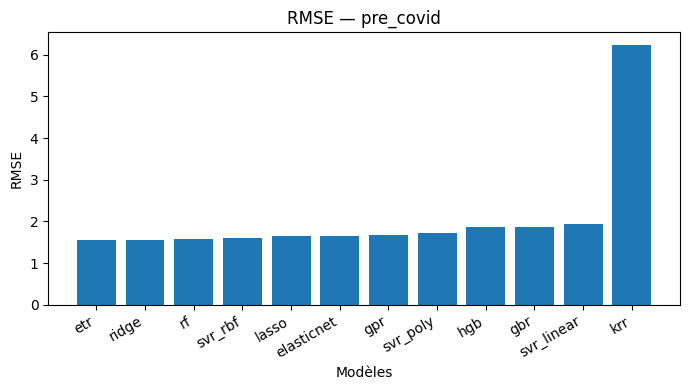

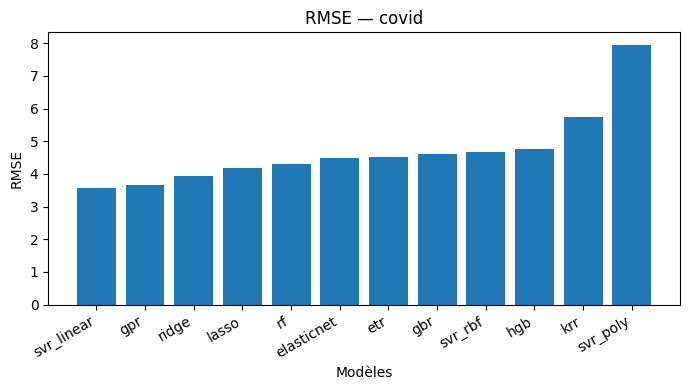

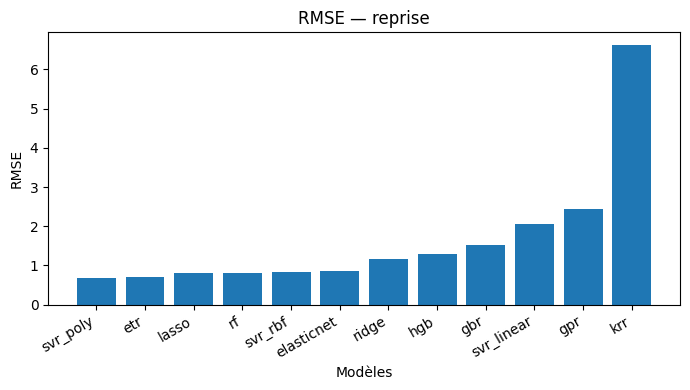

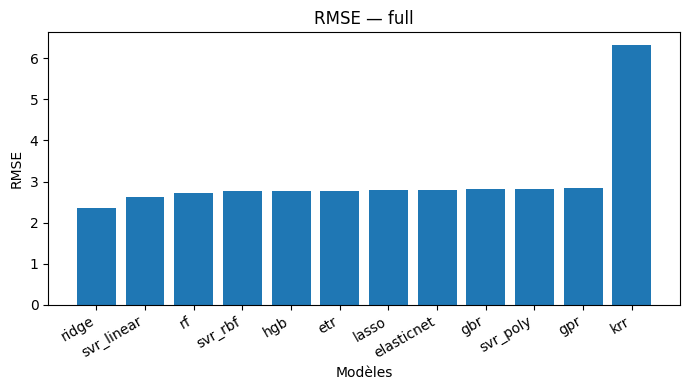

In [22]:

for regime, mdf in results.items():
    if mdf is None or len(mdf)==0 or mdf['RMSE'].notna().sum()==0:
        print(f"[{regime}] Pas de métriques exploitables.")
        continue

    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(mdf['Model'], mdf['RMSE'])
    ax.set_title(f'RMSE — {regime}')
    ax.set_ylabel('RMSE'); ax.set_xlabel('Modèles')
    plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()


## 11) Sauvegarde configuration

In [24]:

cfg = {
    "csv_monthly": csv_monthly,
    "csv_quarterly_target": csv_quarterly_target,
    "periods": SUB_PERIODS,
    "lag_sets": [list(t) for t in LAG_SETS],
    "models": MODELS,
    "n_splits_tscv": N_SPLITS_TSCV,
    "min_train_obs": MIN_TRAIN_OBS
}
os.makedirs("exports_ml_subperiods", exist_ok=True)
with open("exports_ml_subperiods/config_used.json","w",encoding="utf-8") as f:
    json.dump(cfg, f, indent=2, ensure_ascii=False)

print("Config enregistrée -> exports_ml_subperiods/config_used.json")


Config enregistrée -> exports_ml_subperiods/config_used.json
